# Total Outstanding Cases
> The Total Number of Outstanding Cases and Predicted Recoveries by Geographic Area.

- comments: true
- author: Adrian Turcato
- categories: [growth, compare, interactive]
- hide: false
- image: images/covid-outstanding-cases.png
- permalink: /outstanding_cases/
- toc: true

> Note: This dashboard contains the results of a predictive model. The author has tried to make it as accurate as possible. But the COVID-19 situation is changing quickly, and these models inevitably include some level of speculation.

## Outstanding Cases by Geography

The chart below shows the total predicted number of outstanding cases, i.e. number of individuals who are still currently ill.

The chart also represents the reported case fatality rate (CFR) via the color of the country, **which is heavily biased by the amount of testing which is performed in each country**.

> Tip: Change the scale of the y axis with the toggle button and hover over chart areas for more details.

In [1]:
#hide
from IPython.display import HTML, Javascript, display
from string import Template
import numpy as np
import pandas as pd
import json
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import time

In [2]:
#hide
mpl.rcParams['figure.dpi'] = 100
display(Javascript("require.config({paths: {d3: 'https://d3js.org/d3.v2.min.js'}});"))

<IPython.core.display.Javascript object>

In [3]:
#hide
def get_frame(name):
    url = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
        f'csse_covid_19_time_series/time_series_19-covid-{name}.csv')
    df = pd.read_csv(url)
    return df

def get_frameNew(name):
    url = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
        f'csse_covid_19_time_series/time_series_covid19_{name}_global.csv')
    df = pd.read_csv(url)
    return df

def get_frameArchived(name):
    url = (f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/archived_data/archived_time_series/time_series_19-covid-{name}_archived_0325.csv')
    df = pd.read_csv(url)
    return df

def flatten(df):
    array = []
    d = df.to_dict()
    for v in d.items():
        day = v[0]
        for c in v[1].items():
            country = c[0]
            value = c[1]
            array.append({"key":country,"value":value,"date":day})
    return array

def combine(cx,dx,rx):
    all = []
    for i, v in enumerate(cx):
        v['confirmed'] = v['value']
        v['deaths'] = dx[i]['value']
        v['recovered'] = rx[i]['value']
        if cx[i]['key'] != rx[i]['key']:
            print("error: country mismatch")
        if cx[i]['date'] != rx[i]['date']:
            print("error: date mismatch")
        v['value'] = v['value'] - dx[i]['value'] - rx[i]['value']
        if v['value'] < 0:
            print("error:", cx[i]['date'], cx[i]['key'], v['value'], v['confirmed'], dx[i]['value'], rx[i]['value'])
            v['value'] = 0
        #calculate CFR
        fr = 0
        if rx[i]['value'] + dx[i]['value'] + v['value'] > 0:
            fr = dx[i]['value'] / (rx[i]['value'] + dx[i]['value'] + v['value'])
        v['fatality'] = fr
        all.append(v)
    return all;

def makeJSVar(array,varname):
    json_string = json.dumps(array)
    pre = "var " + varname + " ="
    post = ";" #"; get" + varname + " = function (){ return " + varname + "};})();"
    jsVar = pre + json_string + post
    return jsVar

In [4]:
#hide
alternateNames = [
    [["East Timor"],"Timor-Leste"]
    ,[["Taiwan*"],"Taiwan"]
    ,[["Korea, South"],"South Korea"]
    ,[["The Bahamas","Bahamas, The"],"Bahamas"]
    ,[["The Gambia","Gambia, The"],"Gambia"]
    ,[["Cape Verde"],"Cabo Verde"]
    ,[["French Guiana","Guadeloupe","Martinique","Mayotte","Reunion"],"France"]
    ,[["Guam","Puerto Rico"],"US"]
    ,[["Greenland"],"Denmark"]
    ,[["Cruise Ship","Diamond Princess"],"International Conveyance"]
    ,[["Guernsey","Jersey"],"United Kingdom"]
    ,[["Republic of the Congo"],"Congo (Brazzaville)"]
]

def replaceCountries(y):
    for countries in alternateNames:
        if y in countries[0]:
            return countries[1]
    return y
    
def extractGlobal(df):
    df = df.drop(columns=['Province/State', 'Lat', 'Long'])
    df['Country/Region'] = df['Country/Region'].apply(lambda x: replaceCountries(x))
    df = df.groupby('Country/Region').sum()
    return df

abbreviations=[{"name":"Alabama","abbreviation":"AL"},{"name":"Alaska","abbreviation":"AK"},{"name":"American Samoa","abbreviation":"AS"},{"name":"Arizona","abbreviation":"AZ"},{"name":"Arkansas","abbreviation":"AR"},{"name":"California","abbreviation":"CA"},{"name":"Colorado","abbreviation":"CO"},{"name":"Connecticut","abbreviation":"CT"},{"name":"Delaware","abbreviation":"DE"},{"name":"District of Columbia","abbreviation":"D.C."},{"name":"Federated States Of Micronesia","abbreviation":"FM"},{"name":"Florida","abbreviation":"FL"},{"name":"Georgia","abbreviation":"GA"},{"name":"Guam","abbreviation":"GU"},{"name":"Hawaii","abbreviation":"HI"},{"name":"Idaho","abbreviation":"ID"},{"name":"Illinois","abbreviation":"IL"},{"name":"Indiana","abbreviation":"IN"},{"name":"Iowa","abbreviation":"IA"},{"name":"Kansas","abbreviation":"KS"},{"name":"Kentucky","abbreviation":"KY"},{"name":"Louisiana","abbreviation":"LA"},{"name":"Maine","abbreviation":"ME"},{"name":"Marshall Islands","abbreviation":"MH"},{"name":"Maryland","abbreviation":"MD"},{"name":"Massachusetts","abbreviation":"MA"},{"name":"Michigan","abbreviation":"MI"},{"name":"Minnesota","abbreviation":"MN"},{"name":"Mississippi","abbreviation":"MS"},{"name":"Missouri","abbreviation":"MO"},{"name":"Montana","abbreviation":"MT"},{"name":"Nebraska","abbreviation":"NE"},{"name":"Nevada","abbreviation":"NV"},{"name":"New Hampshire","abbreviation":"NH"},{"name":"New Jersey","abbreviation":"NJ"},{"name":"New Mexico","abbreviation":"NM"},{"name":"New York","abbreviation":"NY"},{"name":"North Carolina","abbreviation":"NC"},{"name":"North Dakota","abbreviation":"ND"},{"name":"Northern Mariana Islands","abbreviation":"MP"},{"name":"Ohio","abbreviation":"OH"},{"name":"Oklahoma","abbreviation":"OK"},{"name":"Oregon","abbreviation":"OR"},{"name":"Palau","abbreviation":"PW"},{"name":"Pennsylvania","abbreviation":"PA"},{"name":"Puerto Rico","abbreviation":"PR"},{"name":"Rhode Island","abbreviation":"RI"},{"name":"South Carolina","abbreviation":"SC"},{"name":"South Dakota","abbreviation":"SD"},{"name":"Tennessee","abbreviation":"TN"},{"name":"Texas","abbreviation":"TX"},{"name":"Utah","abbreviation":"UT"},{"name":"Vermont","abbreviation":"VT"},{"name":"Virgin Islands","abbreviation":"VI"},{"name":"Virginia","abbreviation":"VA"},{"name":"Washington","abbreviation":"WA"},{"name":"West Virginia","abbreviation":"WV"},{"name":"Wisconsin","abbreviation":"WI"},{"name":"Wyoming","abbreviation":"WY"}]

def replaceStates(y):
    print(y)
    x = y.split(",")
    if len(x) > 1:
        for i, e in enumerate(abbreviations):
            if e['abbreviation'].strip() == x[1].strip():
                return e['name']
    if y == "United States Virgin Islands":
        return "Virgin Islands"
    return y

def extractUSA(df):
    df = df[df['Country/Region'] == "US"]
    df = df.drop(columns=['Country/Region', 'Lat', 'Long'])
    df = df[~df['Province/State'].isin(["US"])]
    df['Province/State'] = df['Province/State'].apply(lambda x: replaceStates(x))
    df = df.groupby('Province/State').sum()
    dates = df.columns[:32].values
    df = df.drop(columns=dates)
    return df

def extractCanada(df):
    df = df[df['Country/Region'] == "Canada"]
    df = df.drop(columns=['Country/Region', 'Lat', 'Long'])
    df = df.groupby('Province/State').sum()
    dates = df.columns[:32].values
    df = df.drop(columns=dates)
    return df

eu = ['Germany','Finland','Italy','Spain','Belgium','Switzerland','Austria','Greece','Norway','Romania','Estonia','San Marino','Belarus','Iceland','Lithuania','Ireland','Luxembourg','Monaco','Portugal','Andorra','Latvia','Ukraine' 'Hungary','Liechtenstein','Poland','Bosnia and Herzegovina','Slovenia','Serbia','Slovakia','Bulgaria','Albania','Holy See','France','Denmark','Czechia','Moldova','United Kingdom','Kosovo','Netherlands','Montenegro']

def extractEurope(df):
    df = df[df['Country/Region'].isin(eu)]
    df = df.drop(columns=['Province/State', 'Lat', 'Long'])
    df = df.groupby('Country/Region').sum()
    datesEU = df.columns[:32].values
    df = df.drop(columns=datesEU)
    return df



In [5]:
#hide
confirmedRaw = get_frameNew('confirmed')
deathsRaw = get_frameNew('deaths')
recoveredRaw = get_frameArchived('Recovered')

In [6]:
#hide    
def predictRecovered(data):
    c = data["confirmed"]
    d = data['deaths']
    r = data['recovered']
    rp = data['recovered_predicted']
    
    ###Add columns
    for col in c.columns:
        if col not in rp.columns:
            rp[col] = float('nan')
            
    #Replace column values
    for i, row in rp.iterrows():
        for j, v in enumerate(row.values):
            if math.isnan(v):
                date = pd.to_datetime(rp.columns[j])
                dateMinus14 = date - pd.to_timedelta('9 days')
                colMinus14 = dateMinus14.strftime('%-m/%-d/%y')
                lastr = rp.loc[i,rp.columns[j-1]]
                rp.loc[i,rp.columns[j]] = round(lastr + (c.loc[i,colMinus14]-lastr)*0.07)
            
    return {"confirmed":c,"deaths":d,"recovered_predicted":rp,"recovered":r}

def collect(extract):
    c = extract(confirmedRaw)
    r = extract(recoveredRaw)
    d = extract(deathsRaw)
    
    notInC = [x for x in r.index if x not in c.index]
    notInR = [x for x in c.index if x not in r.index]
    
    if len(notInC) > 0:
        print("country mismatch- missing in new data:",notInC)
    
    for country in notInR:
        r.loc[country] = 0
        r = r.sort_index();
    
    data = predictRecovered({"confirmed":c,"deaths":d,"recovered_predicted":r,"recovered":r})
    return data

In [7]:
#hide
globalData = collect(extractGlobal)

In [8]:
#hide
def prepData(data,varname):
    c = flatten(data["confirmed"])
    r = flatten(data["recovered_predicted"])
    d = flatten(data["deaths"])
    all = combine(c,d,r)
    return makeJSVar(all,varname)

In [9]:
#hide
getGlobalDataJson = prepData(globalData,"globalData")
# getUsaDataJson = prepData(extractUSA,"usaData")
# getCanadaDataJson = prepData(extractCanada,"canadaData")
# getEuropeDataJson = prepData(extractEurope,"europeData")

In [10]:
#hide
countries = ["China","Italy","France","Germany","Spain","US","Korea, South","Iran","Switzerland","United Kingdom","Austria","Netherlands","Belgium"]
def topCountries(data,varname):
    confirmed = data['confirmed']
    recovered = data['recovered_predicted']
    deaths = data['deaths']
    df = confirmed - recovered - deaths
    all = []
    l = len(df.columns.values)
    for i in range(0,l):
        day = []
        col = df.columns[i:i+1].values
        sumA = sum(confirmed[col[0]].values)
        #top cases
        nonzero = df[df.index.isin(countries)]
        nonzero = nonzero[nonzero[col[0]] / sumA > 0.0025]
        onecol = nonzero[col[0]]
        onecol = onecol.sort_values(ascending=False)
        topten = onecol #.head(10)
        sumB = sum(topten.values)
        d = topten.to_dict()
        for j, c in enumerate(d.items()):
            day.append({"rank":j,"place":c[0],"count":c[1], "pct":c[1]/sumA, "date":col[0]})
        #all deaths and recoveries
        sumD = sum(deaths[col[0]])
        sumR = sum(recovered[col[0]])
        #all other
        if sumA - (sumB + sumD + sumR) > 0:
            n = int(sumA - (sumB + sumD + sumR))
            m = float(n/sumA)
            day.append({"rank":100,"place":"All Other","count":n, "pct":m, "date":col[0]})
        #add
        day.append({"rank":101,"place":"Recoveries","count":sumR, "pct":sumR/sumA, "date":col[0]})
        day.append({"rank":102,"place":"Deaths","count":sumD, "pct":sumD/sumA, "date":col[0]})
        all.append(day)
    return makeJSVar(all,varname)

In [11]:
#hide
getTopGlobalDataJson = topCountries(globalData,"topGlobalData")

In [12]:
#hide
html_temp = Template('''
    <script src="https://d3js.org/d3.v2.min.js"></script>
    <style scoped>
        $css_text 
    </style>
    <div id="streamgraph">
		<button onclick="toggleScale()" id="toggle">Toggle Scale</button>
		<div class="chart">
		</div>
	</div>
    <script>
        $getGlobal
        
        $d3_script
        
    </script>
''')

In [13]:
#hide
css_text = '''
.chart, .bump-chart {
  font: 10px sans-serif;
  background: #fff;
  height: 575px;
}

.stream-tooltip, .bump-tooltip {
  font: 10px sans-serif;
}

.axis path, .axis line {
  fill: none;
  stroke: #000;
  stroke-width: 1px;
  shape-rendering: crispEdges;
}

.buttons {
  font: 11px sans-serif;
  position: relative;
  left: 50px;
  top: 10px;
}

#toggle {
  font: 11px sans-serif;
  position: relative;
  left: 660px;
  top: 10px;
}'''

In [14]:
#hide
d3_script = '''
    drawStream();
    function drawStream(){
        var margin, width, height;
        var svg, tooltip, area, blank;
        var y, x, yAxis, xAxis;

        var data, layers, logScale;
        var usaLayers, globalLayers, euLayers;
        var dataClass, prevClass;

        margin = {top: 20, right: 70, bottom: 100, left: 30};
        width = 750 - margin.left - margin.right;
        height = 550 - margin.top - margin.bottom;

        svg = d3.select(".chart").append("svg")
            .attr("id","stream-svg")
            .attr("width", width + margin.left + margin.right)
            .attr("height", height + margin.top + margin.bottom)
            .append("g")
            .attr("transform", "translate(" + margin.left + "," + margin.top + ")");

        var cs = d3.scale.linear()
            .domain([0,0.5,1])
            .interpolate(d3.interpolateRgb)
            .range([d3.rgb('#cc0000'),d3.rgb(249, 247, 174),d3.rgb(0, 104, 55)]);

        var format = d3.time.format("%m/%d/%y");
        function formatDate (d) {
            d.date = format.parse(d.date);
            d.value = +d.value;
        } 

        // axis
        x = d3.time.scale()
            .range([0, width])
            .clamp(true);

        xAxis = d3.svg.axis()
            .orient("bottom")
            .ticks(d3.time.weeks);
            // .tickFormat(d3.time.format("%b %d"));

        svg.append("g")
            .attr("class", "x axis")
            .attr("transform", "translate(0," + height + ")");		

        yAxis = d3.svg.axis()
            .orient("right") 
            .tickFormat(d3.format(","));

        svg.append("g")
            .attr("class", "y axis")
            .attr("transform", `translate(${width + 10}, 0)`);

        // clipping paths
        svg.append("defs")
            .append("clipPath")
            .attr("id","clip")
            .append("rect")
            .attr("width",width)
            .attr("height",height-10)
            .attr("x",0)
            .attr("y",0);

        svg.append("text")
            .attr("text-anchor", "middle") 
            .attr("transform", "translate("+ (width + margin.right*0.8) +","+(height/2)+")rotate(90)")  
            .text("Current Outstanding Cases");

        svg.append("text")
            .attr("text-anchor", "middle")  
            .attr("transform", "translate("+ (width/2) +","+(height + 40)+")")  
            .text("Date");

        area = d3.svg.area()
            .interpolate("cardinal")
            .x(d => x(d.date));

        blank = d3.svg.area()
            .interpolate("cardinal")
            .x(d => x(d.date));

        //usaData.forEach(formatDate);
        //usaLayers = prepareData(usaData);

        globalData.forEach(formatDate);
        globalLayers = prepareData(globalData);

        //europeData.forEach(formatDate);
        //euLayers = prepareData(europeData);

        //canadaData.forEach(formatDate);
        //canadaLayers = prepareData(canadaData);

        dataClass = "globalData";
        prevClass = "usaData";

        data = globalData;
        layers = globalLayers;
        logScale = true;

        drawScale();
        drawLegend();
        draw();

        toggleScale = function (){
            logScale = !logScale;
            drawScale();
        }
        toggleUSA = function(){
            prevClass = dataClass;
            dataClass = "usaData";

            data = usaData;
            layers = usaLayers;
            drawScale();
            draw();
        }
        toggleGlobal = function (){
            prevClass = dataClass;
            dataClass = "globalData";

            data = globalData;
            layers = globalLayers;
            drawScale(); 
            draw();
        }
        toggleEU = function(){
            prevClass = dataClass;
            dataClass = "europeData";

            data = europeData;
            layers = euLayers;
            drawScale();
            draw();
        }
        toggleCanada = function(){
            prevClass = dataClass;
            dataClass = "canadaData";

            data = canadaData;
            layers = canadaLayers;
            drawScale();
            draw();
        }
        function drawScale(){
            area.y0(d => {return y(d.y0 + 1)})
                .y1(d => {return y(d.y0 + d.y + 1)});
            blank.y0(d => height)
                .y1(d => height);

            var yExt = d3.extent(data, d => {return d.y0 + d.y});
            var logMin = 1000;
            if(dataClass == "usaData") logMin = 300;
            if(dataClass == "canadaData") logMin = 10;
            y = d3.scale.log()
                .range([height-10, 0])
                .domain([yExt[1]/200,yExt[1]])
                .clamp(true);
            if(!logScale){
                y = d3.scale.linear()
                    .range([height-10, 0])
                    .domain(yExt)
                    .clamp(true);
            }
            yAxis.scale(y);

            x.domain(d3.extent(data, d => d.date));
            xAxis.scale(x);

            svg.selectAll(".y")
                .transition("axis")
                .duration(1000)
                .call(yAxis);

            svg.selectAll(".x")
                .transition("axis")
                .duration(1000)
                .call(xAxis);
                // .selectAll("text")  
                // .style("text-anchor", "end")
                // .attr("dx", "-.8em")
                // .attr("dy", ".15em")
                // .attr("transform", "rotate(-65)" );

            svg.selectAll(".layer")
                .transition("axis")
                .duration(1000)
                .attr("d", d => area(d.values))	
        }
        function draw(){
            var leaving = svg.selectAll(`.${prevClass}`);
            leaving.transition("load")
                .duration(1000)
                .attr("d", d => blank(d.values))
                .remove();

            var countries = svg.selectAll(`.${dataClass}`)
                .data(layers);

            countries.enter()
                .append("path")
                .attr("d", d => blank(d.values))
                .on("mousemove", d => updateTooltip(d))
                .on("mouseout", function(d, i) {
                    tooltip.style("visibility", "hidden");
                })
                .transition("load")
                .duration(1000)
                .attr("d", d => blank(d.values))
                .attr("class", `layer ${dataClass}`)
                .attr("d", d => area(d.values))
                .attr("fill", d => {return `url(#${d.gradient})`})
                .attr("clip-path","url(#clip)")
                .attr("opacity", 1);
        }
        function drawLegend(){
            var defs = svg.append("defs");

            var gradient = defs.append("linearGradient")
               .attr("id", "legend-grad")
               .attr("x1", "0%")
               .attr("x2", "100%")
               .attr("y1", "0%")
               .attr("y2", "0%");

            for(var i = 0; i <= 10; i++){
                gradient.append("stop")
                    .attr("offset", `${i*10}%`)
                    .attr("stop-color", cs(1-i/10)) // d3.interpolateRdYlGn(1-i/10))
                    .attr("stop-opacity", 1);
            }

            var legend = svg.append("g")
                .attr("id","legend")
                .attr("transform", `translate(${(width/2)-150},${height+65})`)
            legend.append("rect")
                .attr("width",300)
                .attr("height",15)
                .attr("fill", "url(#legend-grad)");
            legend.append("text")
                .attr("text-anchor", "end") 
                .attr("transform", "translate("+ -10 +","+10+")")  
                .text("Case Fatality Rate (CFR)");

            var lScale = d3.scale.linear()
                .range([0, 300])
                .domain([0.0,0.1]);

            var lAxis = d3.svg.axis()
                .orient("bottom") 
                .scale(lScale)
                .tickSize(18,0)
                .tickFormat(d3.format(".1%"));

            var l2 = svg.append("g")
                .attr("class", "legend-axis axis")
                .attr("transform", `translate(${(width/2)-150},${height+65})`)
                .call(lAxis);

            l2.selectAll("path")
                .remove();
        }
        function prepareData(data){
            //manipulate data
            var nest = d3.nest()
                .key(function(d) { return d.key; });
            var alphabetic = nest.entries(data);
            var l = alphabetic.length;

            //order data
            for(var i = 0; i < l; i++){
                var vals = alphabetic[i].values;
                var lv = vals.length;
                var current = vals[lv-1];
                alphabetic[i].fatality = current.fatality;
                alphabetic[i].current = current.value;
                alphabetic[i].index = i
            }
            alphabetic.sort((a,b) => (a.current - b.current));

            var stack = d3.layout.stack()
              .offset("zero")
              .order(() => alphabetic.map(e => e.index))
              .values(d => d.values)
              .x(d => d.date)
              .y(d => d.value);

            //add color gradients
            for(var i = 0; i < l; i++){
                var name = alphabetic[i].key.replace(/\s/g, '')
                var id = `gradient-${name}`;
                alphabetic[i].gradient = id;

                var defs = svg.append("defs");

                var gradient = defs.append("linearGradient")
                   .attr("id", id)
                   .attr("x1", "0%")
                   .attr("x2", "100%")
                   .attr("y1", "0%")
                   .attr("y2", "0%");

                var values = alphabetic[i].values;
                var lv = alphabetic[i].values.length;

                for(var j = 0; j < lv; j++){
                    var offset = `${Math.round(j*100/(lv-1))}%`;
                    var fr = values[j].fatality/0.1;
                    var col = cs(1-fr); //d3.interpolateRdYlGn(1-fr);

                    gradient.append("stop")
                        .attr("offset", offset)
                        .attr("stop-color", col)
                        .attr("stop-opacity", 1);  
                }
            }

            var layers = stack(nest.entries(data));
            for(var i = 0; i < l; i++){
                var name = layers[i].key.replace(/\s/g, '')
                var id = `gradient-${name}`;
                layers[i].gradient = id;
            }
            return layers;
        }
        function updateTooltip(d){
            var leftOffset = document.getElementById("stream-svg").getBoundingClientRect().left;
            var date = roundDate(x.invert(event.clientX - leftOffset - margin.left));
            var val = d.values[d.values.length-1];
	  		d.values.forEach(e => {
                if(e.date.getTime()==date.getTime()){
                    val = e;
                }
            })
            
            var current = d3.format(",")(val.value)
            var deaths = d3.format(",")(val.deaths)
            var recoveries = d3.format(",")(val.recovered)
            var fatality = d3.format(".1%")(val.fatality)
            var day = d3.time.format("%m/%d/%y")(val.date)
            var n = d.key;

            tooltip = svg.selectAll(".stream-tooltip")
                .data([n,day,`est. cases: ${current}`,`deaths: ${deaths}`,`recoveries: ${recoveries}`,`CFR: ${fatality}`]);
            tooltip.style("visibility", "visible")
                .attr("opacity",1)
                .text(d => d);
            tooltip.enter()
                .append("text")
                .attr("class", "stream-tooltip")
                .attr("x","0")
                .attr("y",(d,i) => `${i}em`)
                .attr("font-weight", (d,i) => i == 0 ? "bold" : "normal")
                .attr("opacity",1)
                .text(d => d);
        }
        
        function roundDate(timeStamp){
		    var d = new Date(timeStamp);
				d.setHours(0);
				d.setMinutes(0);
				d.setSeconds(0);
				d.setMilliseconds(0);
			return d;
		}
    }
'''

In [15]:
#hide
html_text = html_temp.substitute({
    'css_text':css_text
    ,'d3_script':d3_script
    ,"getGlobal":getGlobalDataJson
#     ,"getUSA":getUsaDataJson
#     ,"getEU":getEuropeDataJson
#     ,"getCanada":getCanadaDataJson
})

In [16]:
#hide_input
HTML(html_text)

The table below shows summary statistics for the last 7 days.  $Oustanding = Confirmed - Deaths - Recovered$.

In [17]:
#hide_input
totalConfirmed = globalData['confirmed'].sum(axis=0) 
totalDeaths = globalData['deaths'].sum(axis=0) 
totalRecovered = pd.to_numeric(globalData['recovered'].sum(axis=0), downcast='integer')
frame = {'Confirmed': totalConfirmed, 'Deaths': totalDeaths, 'Est. Recoveries': totalRecovered, 'Outstanding':totalConfirmed-totalDeaths-totalRecovered}
result = pd.DataFrame(frame)
result = result.set_index(pd.to_datetime(result.index)).sort_index()
result.tail(7)

,Confirmed,Deaths,Est. Recoveries,Outstanding
2020-04-06,1345101,74565,290059,980477
2020-04-07,1426096,81865,320159,1024072
2020-04-08,1511104,88338,352503,1070263
2020-04-09,1595350,95455,387850,1112045
2020-04-10,1691719,102525,425983,1163211
2020-04-11,1771514,108503,467103,1195908
2020-04-12,1846679,114091,511111,1221477


## Percent of Global Total

This next chart shows the number of outstanding cases as a percent of the total confirmed global cases. Only countries representing a significant contribution to global totals are shown.

> Tip: Hover over chart areas for more details.

In [18]:
#hide
areabump_temp = Template('''
    <script src="https://d3js.org/d3.v2.min.js"></script>
    <style scoped>
        $css_text 
    </style>
    <div id="bumpchart">
		<div class="bump-chart">
		</div>
	</div>
    <script>
        $getTopGlobal
        
        $d3_bump_script
    </script>
''')

In [19]:
#hide
d3_bump_script = '''
    drawBump();
    function drawBump(){
        var colors = {
            "Korea, South":"darkred"
			,"China":"pink"
			,"US":"blue"
			,"United Kingdom":"orange"
			,"France":"lightblue"
			,"Germany":"yellow"
			,"Italy":"tan"
			,"Spain":"purple"
			,"Switzerland":"violet"
			,"Iran":"green"
            ,"Netherlands":"cyan"
            ,"Austria":"teal"
            ,"Belgium":"brown"
			,"All Other":"lightgray"
            ,"Recoveries":"lightgreen"
            ,"Deaths":"#ff590d"
		};

		var margin, width, height;
		var svg, tooltip, area, blank;
		var x, y, h, yAxis, xAxis;

		var data, layers, logScale, numDays;
		var dataClass = "globalData", prevClass;

		var format = d3.time.format("%m/%d/%y");
		var nest = d3.nest()
			.key(function(d) { return d.place; });	

        margin = {top: 20, right: 60, bottom: 40, left: 30};
        width = 750 - margin.left - margin.right;
        height = 500 - margin.top - margin.bottom;

		svg = d3.select(".bump-chart").append("svg")
            .attr("id","bump-svg")
	    	.attr("width", width + margin.left + margin.right)
	    	.attr("height", height + margin.top + margin.bottom)
	    	.append("g")
	    	.attr("transform", "translate(" + margin.left + "," + margin.top + ")");
        
		// axis
		x = d3.time.scale()
			.range([0, width])
			.clamp(true);
			
	  	xAxis = d3.svg.axis()
			.orient("bottom")
			.ticks(d3.time.weeks);

	  	svg.append("g")
			.attr("class", "x-bump axis")
			.attr("transform", `translate(0,${height-5})`);		

		yAxis = d3.svg.axis()
			.orient("right") 
	    	.tickFormat(d3.format("%"));

		svg.append("g")
	    	.attr("class", "y-bump axis")
	    	.attr("transform", `translate(${width+10}, 0)`);

	    // clipping paths
	  	svg.append("defs")
		    .append("clipPath")
		    .attr("id","clip-bump")
		    .append("rect")
		    .attr("width", width)
		    .attr("height", height-10)
		    .attr("x",0)
		    .attr("y",0);

		svg.append("text")
			.attr("text-anchor", "middle") 
			.attr("transform", "translate("+ (width + margin.right*0.8) +","+(height/2)+")rotate(90)")  
			.text("% of Total Cases");

	  	svg.append("text")
			.attr("text-anchor", "middle")  
			.attr("transform", "translate("+ (width/2) +","+(height + 40)+")")  
			.text("Date");

	  	area = d3.svg.area()
	      	.interpolate("basis")
	      	.x(d => x(d.date));
	    blank = d3.svg.area()
	      	.interpolate("basis")
	      	.x(d => x(d.date));

		globalTuple = prepareData(topGlobalData);
		data = globalTuple.data;
		numDays = topGlobalData.length;
		layers = globalTuple.layers;
		logScale = false;

		drawScale();
	  	draw();

	  	this.toggleBumpScale = function (){
	    	logScale = !logScale;
	    	drawScale();
	    }
	    function drawScale(){
		   	area.y0(d => {return y(d.y0)})
	      		.y1(d => {return y(d.y0 + d.y)});
	      	blank.y0(d => height)
	      		.y1(d => height);

            y = d3.scale.linear()
                .range([height-10, 0])
                .domain([0,1]);
		    yAxis.scale(y);

		    x.domain(d3.extent(data, d => d.date));
		    xAxis.scale(x);

		    svg.selectAll(".y-bump")
				.transition("axis")
				.duration(1000)
				.call(yAxis);
				
		    svg.selectAll(".x-bump")
				.transition("axis")
				.duration(1000)
				.call(xAxis);

		    svg.selectAll(".layer-bump")
		    	.transition("axis")
				.duration(1000)
				.attr("d", d => area(d.values))	
	    }
		function draw(){
		    var countries = svg.selectAll(`.${dataClass}`)
				.data(layers);
                
		    countries.enter()
		    	.append("path")
		    	.attr("d", d => blank(d.values))
	    		.on("mousemove", d => updateBumpTooltip(d))
	    		.on("mouseout", function(d, i) {
	      			tooltip.style("visibility", "hidden");
	  			})
		    	.transition("load")
				.duration(1000)
		    	.attr("d", d => blank(d.pct))
				.attr("class", `layer-bump ${dataClass}`)
				.attr("d", d => area(d.values))
				.attr("fill", (d,i) => colors[d.key]) //d => {return `url(#${d.gradient})`})
				.attr("stroke","black")
				.attr("opacity", 1);
	  	}	
	  	function updateBumpTooltip(d){
            var leftOffset = document.getElementById("bump-svg").getBoundingClientRect().left;
            var date = roundDate(x.invert(event.clientX - leftOffset - margin.left));
            var val = d.values[d.values.length-1];
	  		d.values.forEach(e => {
                if(e.date.getTime()==date.getTime()){
                    val = e;
                }
            })
            
			var current = d3.format(",")(val.count)
			var pct = d3.format("%")(val.pct)
			var day = d3.time.format("%m/%d/%y")(val.date)
			var n = d.key;

		    tooltip = svg.selectAll(".bump-tooltip")
				.data([n,day,`est. cases: ${current}`,`percent: ${pct}`]);
			tooltip.style("visibility", "visible")
				.text(d => d);
		    tooltip.enter()
		    	.append("text")
		    	.attr("class", "bump-tooltip")
		    	.attr("x","10")
		    	.attr("y",(d,i) => `${2+i}em`)
		    	.attr("font-weight", (d,i) => i == 0 ? "bold" : "normal")
		    	.text(d => d);
		}

	  	function prepareData(data){
	  		//fill in zeros
	  		/*var ld = data.length;
	  		for(var i = 0; i < ld; i++){
	  			var b = data[i].map(x => x.place);
	  			var lb = b.length; 
	  			if(i-1 >= 0) var a = data[i-1].map(x => x.place);
	  			if(i+1 < ld) var c = data[i+1].map(x => x.place);
	  			for(var j = 0; j < lb; j++){
	  				if(i-1 >= 0){
	  					if(a.indexOf(b[j]) == -1){
		  					data[i-1].push({"rank":11,"place":data[i][j].place,"count":0,"pct":0,"date":data[i][j].date});
	  					}
	  				}
	  				if(i+1 < ld){
	  					if(c.indexOf(b[j]) == -1){
		  					data[i+1].push({"rank":11,"place":data[i][j].place,"count":0,"pct":0,"date":data[i][j].date});
	  					}
					}
	  			}
	  		}*/

			//find a y and y0 for each data point
			var ld = data.length;
			var flat = [];
			for(var i = 0; i < ld; i++){
				var sum = 0;
				var padding = 0;
				var lid = data[i].length;
				while(lid--){
					data[i][lid]["date"] = format.parse(data[i][lid]["date"]);
					data[i][lid]["y0"] = sum;
					data[i][lid]["y"] = data[i][lid]["pct"];
					flat.push(data[i][lid])
					sum += data[i][lid]["pct"] + padding;
				}
			}

			var layers = nest.entries(flat);
            layers = layers.sort(
                (a,b) => b.values[b.values.length-1].rank - a.values[a.values.length-1].rank
            );
			return {data:flat, layers:layers}
		}  	

		function roundDate(timeStamp){
		    var d = new Date(timeStamp);
				d.setHours(0);
				d.setMinutes(0);
				d.setSeconds(0);
				d.setMilliseconds(0);
			return d;
		}
    }
'''

In [20]:
#hide
areabump_text = areabump_temp.substitute({
    'css_text':css_text
    ,'d3_bump_script':d3_bump_script
    ,'getTopGlobal':getTopGlobalDataJson
})

In [21]:
#hide_input
HTML(areabump_text)

## Appendix: Methodology of Predicting Recovered Cases
[John Hopkin's University's (JHU) dataset](https://systems.jhu.edu/research/public-health/ncov/) initially reported recovered cases but has since discontinued this, however estimating the recovery duration and extrapolating for current cases should be possible from this original data.

For the time being (I hope to draw from other discussions of this topic), I will use an empirically derived formula from the limited data available from JHU:

{% raw %}$$R_{n} = R_{n-1} + (C_{n-9} - R_{n-1})*0.07$${% endraw %}

Where $R_{n}$ is the total number of recovered cases on day $n$, and $C_{n}$ is the total number of confirmed cases on day $n$.

What it implies is that on a given day, of the cases which were first reported 9 days previously 7% of those cases would have either recovered or passed away. After 16 days therefore 49% of cases would have recovered or passed away and after 23 days 98% of cases would have recovered or passsed away.

This formula is only being used to predict the number of recoveries from the time that JHU's data is not available. We can compare the results of this formula to the existing data from JHU to show the level of fit. This can be seen in the following 2 graphs.

In [22]:
#hide
totalConfirmedChina = globalData['confirmed'].loc["China"]
tcvC = totalConfirmedChina.values
totalRecoveredC = pd.to_numeric(globalData['recovered'].loc["China"], downcast='integer')
trvC = totalRecoveredC.values
tprvC = trvC[:9]

#calculate 
for n in range(9,len(tcvC)):
    v = tprvC[n-1] + (tcvC[n-9] - tprvC[n-1])*0.07
    tprvC = np.append(tprvC,v)
    
frameC = {"Predicted Recoveries":tprvC,'Recoveries': totalRecoveredC}
resultC = pd.DataFrame(frameC)
resultC = resultC.set_index(pd.to_datetime(resultC.index)).sort_index()

In [23]:
#hide
totalConfirmedGlobal = globalData['confirmed'].sum(axis=0) 
tcvG = totalConfirmedGlobal.values
totalRecoveredGlobal = pd.to_numeric(globalData['recovered'].sum(axis=0), downcast='integer')
trvG = totalRecoveredGlobal.values
tprvG = trvG[:9]

#calculate 
for n in range(9,len(tcvG)):
    v = tprvG[n-1] + (tcvG[n-9] - tprvG[n-1])*0.07
    tprvG = np.append(tprvG,v)
frameG = {"Predicted Recoveries":tprvG,'Recoveries': totalRecoveredGlobal}
resultG = pd.DataFrame(frameG)
resultG = resultG.set_index(pd.to_datetime(resultG.index)).sort_index()

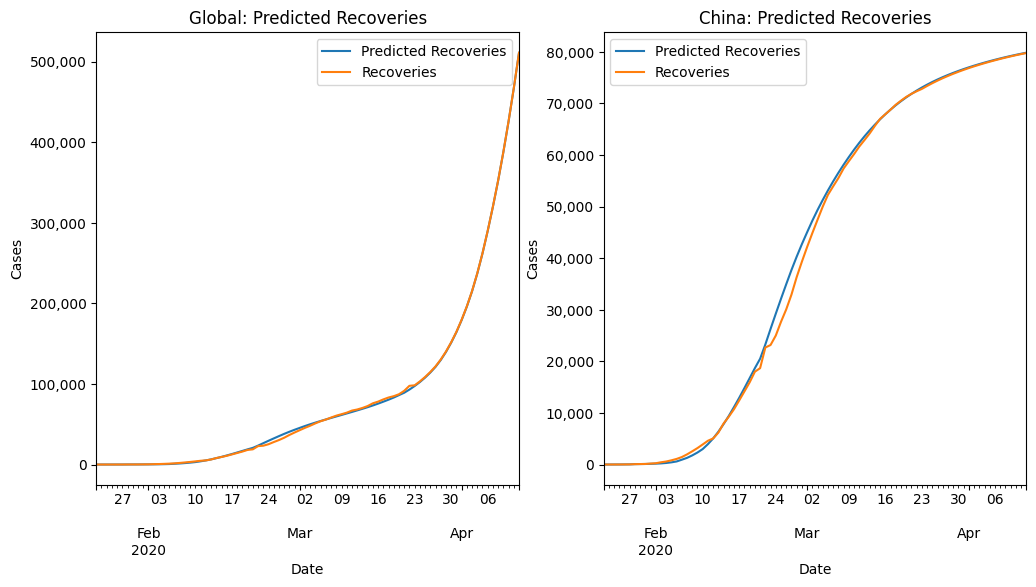

In [24]:
#hide_input
#create subplot figure with having two side by side plots
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
axes[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
axes[1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
axes[0].set_xlabel('Date')
axes[1].set_xlabel('Date')
axes[0].set_ylabel('Cases')
axes[1].set_ylabel('Cases')
axes[0].set_title('Global: Predicted Recoveries')
axes[1].set_title("China: Predicted Recoveries")
resultG.plot(ax = axes[0]) 
resultC.plot(ax = axes[1])
plt.show()

Visualizations and analysis by [Adrian Turcato](https://www.linkedin.com/in/adrian-turcato-9a543185/)[^1]

[^1]: Source: ["COVID-19 Data Repository by Johns Hopkins CSSE"](https://systems.jhu.edu/research/public-health/ncov/) [GitHub repository](https://github.com/CSSEGISandData/COVID-19).
 